In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

### Device 설정 확인

In [3]:
# DEVICE의 출력으로 cuda가 나오는지 확인합니다.
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('DEVICE :', DEVICE)

DEVICE : cuda


### MNIST Dataset 준비

In [4]:
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    ])

# MNIST dataset을 준비합니다. 필요시 다운로드 받습니다.
train_data = datasets.MNIST('mnist_data', train=True, download=True, transform=transform)
print(train_data)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: mnist_data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


### Data Loader를 만듭니다.

In [5]:
# MNIST dataset을 트레이닝과 테스트에 사용할 수 있도록 Data Loader를 만듭니다.
train_loader = torch.utils.data.DataLoader(train_data, batch_size=32)
print('done')

done


### ConvLayer, ResBlock

In [6]:
# Conv 1x1, Conv 3x3, Conv 3x3, Conv 1x1
class ConvLayer(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, last_zero=False):
        super().__init__()
        self.convs = nn.Sequential(nn.Conv2d(in_channels, hidden_channels, kernel_size=1),
                                  nn.GELU(),
                                  nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
                                  nn.GELU(),
                                  nn.Conv2d(hidden_channels, hidden_channels, kernel_size=3, padding=1),
                                  nn.GELU())
        self.last_conv = nn.Conv2d(hidden_channels, out_channels, kernel_size=1)
        if last_zero:
            self.last_conv.weight.data.zero_()
        
    def forward(self, x):
        y = self.convs(x)
        y = self.last_conv(y)
        return y
    
# Conv 1x1, Conv 3x3, Conv 3x3, Conv 1x1, residual connection
class ResBlock(nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv = ConvLayer(in_channels, hidden_channels, in_channels)
        
    def forward(self, x):
        y = x + self.conv(x)
        return y

### Encoder

In [7]:
class EncoderBlock(nn.Module):
    def __init__(self, encoder_channels, hidden_channels, n_blocks):
        super().__init__()
        self.res_blocks = nn.ModuleList([ResBlock(encoder_channels, hidden_channels)\
                                         for _ in range(n_blocks)])
        
    def forward(self, x):
        xs = []
        for res_block in self.res_blocks:
            x = res_block(x)
        return x

In [8]:
class Encoder(nn.Module):
    def __init__(self, in_channels, encoder_channels, hidden_channels, n_blocks, n_layers):
        super().__init__()
        self.in_layer = nn.Conv2d(in_channels, encoder_channels, kernel_size=1)
        self.encoder_blocks = nn.ModuleList([EncoderBlock(encoder_channels, hidden_channels, n_blocks)\
                                            for _ in range(n_layers)])
        self.downs = nn.ModuleList([nn.Conv2d(encoder_channels, encoder_channels, kernel_size=2, stride=2)\
                                   for _ in range(n_layers-1)])
        self.downs.append(None)
        
    def forward(self, x):
        # x : (batch, in_channels, height, width)
        
        #(batch, hidden_channels, height, width)
        x = self.in_layer(x)
        xs = []
        for block, down in zip(self.encoder_blocks, self.downs):
            x = block(x)
            xs.append(x)
            if down is not None:
                x = down(x)
        xs.reverse()
        return xs
        

### Decoder

In [9]:
class TopdownBlock(nn.Module):
    def __init__(self, in_channels, hidden_channels, z_channels, encoder_channels, standard_prior=True):
        super().__init__()
        self.z_channels = z_channels
        self.standard_prior = standard_prior
        self.q = ConvLayer(in_channels + encoder_channels, hidden_channels, z_channels*2, last_zero=True)
        if not standard_prior:
            self.p = ConvLayer(in_channels, hidden_channels, z_channels*2, last_zero=True)
        self.z_proj = nn.Conv2d(z_channels, in_channels, kernel_size=1)
        self.out_proj = ConvLayer(in_channels, hidden_channels, in_channels)
        
    # KL(q||p), KL-divergence between two Gaussian distributions
    def _get_kl_div(self, q_params, p_params):
        p_mean = p_params[0]
        p_logstd = q_params[1]
        q_mean = q_params[0]
        q_logstd = q_params[1]
        return p_logstd - q_logstd + (q_logstd.exp()**2 + (q_mean-p_mean)**2)/(2*p_logstd.exp()**2) - 0.5
    
    def _get_kl_div_with_stardard_normal(self, q_params):
        q_mean = q_params[0]
        q_logstd = q_params[1]
        return -q_logstd + (q_logstd.exp()**2 + q_mean**2)/2 - 0.5 
    
    def _sample(self, params, temperature=1.0):
        mean = params[0]
        logstd = params[1]
        sample = mean + mean.new(mean.shape).normal_() * logstd.exp() * temperature
        return sample
        
    def forward(self, x, enc):
        # x : (batch, in_channels, height, width)
        # enc : (batch, encoder_channels, height, width)
        
        # (batch, z_channels, height, width), (batch, z_channels, height, width)
        q_params = self.q(torch.cat([x, enc], dim=1)).split(self.z_channels, dim=1)
        if not self.standard_prior:
            # (batch, z_channels, height, width), (batch, z_channels, height, width)
            p_params = self.p(x).split(self.z_channels, dim=1)
            kl_div = self._get_kl_div(q_params, p_params)
        else:
            kl_div = self._get_kl_div_with_stardard_normal(q_params)
        z = self._sample(q_params)
        x = x + self.z_proj(z)
        x = x + self.out_proj(x)
        outputs = {'x': x,
                   'kl_div': kl_div}
        return outputs
    
    def inference(self, x, temperature):
        # x : (batch, in_channels, height, width)
        
        if not self.standard_prior:
            # (batch, z_channels, height, width), (batch, z_channels, height, width)
            p_params = self.p(x).split(self.z_channels, dim=1)
            z = self._sample(p_params, temperature)
        else:
            z = x.data.new(x.shape[0], self.z_channels, x.shape[2], x.shape[3]).normal_() * temperature
        x = x + self.z_proj(z)
        x = x + self.out_proj(x)
        return x

In [10]:
class DecoderBlock(nn.Module):
    def __init__(self, decoder_channels, hidden_channels, z_channels, encoder_channels, n_blocks):
        super().__init__()
        self.topdown_blocks = nn.ModuleList([TopdownBlock(decoder_channels, hidden_channels, z_channels, encoder_channels)\
                                            for _ in range(n_blocks)])
        
    def forward(self, x, enc):
        kl_divs = []
        for topdown_block in self.topdown_blocks:
            outputs = topdown_block(x, enc)
            x = outputs['x']
            kl_divs.append(outputs['kl_div'])
        outputs = {'x': x,
                   'kl_divs': kl_divs}
        return outputs
    
    def inference(self, x, temperature):
        for topdown_block in self.topdown_blocks:
            x = topdown_block.inference(x, temperature)
        return x

In [11]:
class Decoder(nn.Module):
    def __init__(self, decoder_channels, hidden_channels, z_channels, encoder_channels, out_channels, n_blocks, n_layers):
        super().__init__()
        self.decoder_channels = decoder_channels
        self.n_layers = n_layers
        self.decoder_blocks = nn.ModuleList([DecoderBlock(decoder_channels, hidden_channels, z_channels, encoder_channels, n_blocks)\
                                            for _ in range(n_layers)])
        self.ups = nn.ModuleList([nn.ConvTranspose2d(decoder_channels, decoder_channels, kernel_size=2, stride=2)\
                                 for _ in range(n_layers-1)])
        self.ups.append(None)
        self.out_layer = nn.Conv2d(decoder_channels, out_channels, kernel_size=1)
        
    def forward(self, encs):
        batch, _, height, width = encs[0].size()
        x = torch.zeros(batch, self.decoder_channels, height, width).to(encs[0].device)
        
        kl_divs = []
        for decoder_block, up, enc in zip(self.decoder_blocks, self.ups, encs):
            outputs = decoder_block(x, enc)
            x = outputs['x']
            if up is not None:
                x = up(x)
            kl_divs.extend(outputs['kl_divs'])
        x = self.out_layer(x)
        outputs = {'x': x,
                   'kl_divs': kl_divs}
        return outputs
        
    def inference(self, batch, height, width, temperature):
        x = torch.zeros(batch, self.decoder_channels, height//(2**(self.n_layers-1)), width//(2**(self.n_layers-1))).cuda()
        
        for decoder_block, up in zip(self.decoder_blocks, self.ups):
            x = decoder_block.inference(x, temperature)
            if up is not None:
                x = up(x)
        x = self.out_layer(x)
        return x

### 전체 모델

In [12]:
class VDVAE(nn.Module):
    def __init__(self, in_channels=1, encoder_channels=16, decoder_channels=16,
                 hidden_channels=64, z_channels=1, n_blocks=3, n_layers=5):
        super().__init__()
        self.encoder = Encoder(in_channels, encoder_channels, hidden_channels, n_blocks, n_layers)
        self.decoder = Decoder(decoder_channels, hidden_channels, z_channels, encoder_channels, in_channels, n_blocks, n_layers)
    
    def forward(self, x):
        # x : (batch, in_channels, height, width)
        
        encs = self.encoder(x)
        outputs = self.decoder(encs)
        return outputs
    
    def inference(self, batch, height, width, temperature=1.0):
        x = self.decoder.inference(batch, height, width, temperature)
        x = torch.sigmoid(x)
        return x
    
    def get_loss(self, x, y, kl_divs):
        # reconstruction loss
        #recon_loss = ((x - y)**2).sum(dim=[1, 2, 3])
        recon_loss = F.binary_cross_entropy_with_logits(y, x, reduction='none').sum(dim=[1, 2, 3])
        
        # KL-divegence loss
        kl_loss = None
        for kl in kl_divs:
            kl_loss = kl.sum(dim=[1, 2, 3]) if kl_loss is None else kl_loss + kl.sum(dim=[1, 2, 3])
        dim = x.size(1) * x.size(2) * x.size(3)
        
        # total loss
        total_loss = recon_loss + kl_loss
        loss = {'recon_loss': recon_loss.mean(),
                'kl_loss': kl_loss.mean(),
                'total_loss': total_loss.mean()}
        return loss
    

### 모델과 optimizer 생성

In [13]:
model = VDVAE().cuda()
optimizer = torch.optim.Adam(model.parameters(), 1e-3)
step = 0
print('done')

done


In [14]:
def plot(image_array, title):
    print(title)
    plt.figure(figsize=[18, 3])
    for i in range(20):
        plt.subplot(1, 20, i+1)
        plt.imshow(image_array[i, 0], cmap='Greys')
        plt.xticks([])
        plt.yticks([])
    plt.show()

### 모델 트레이닝

Original


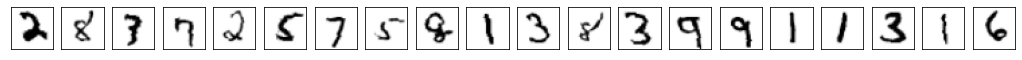

Reconstructed


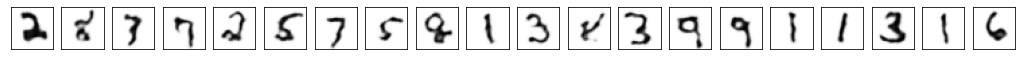

Unconditional samples with Temperature 0.0


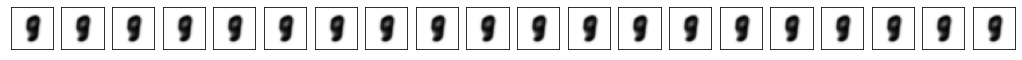

Unconditional samples with Temperature 0.333


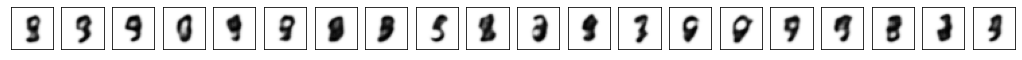

Unconditional samples with Temperature 0.666


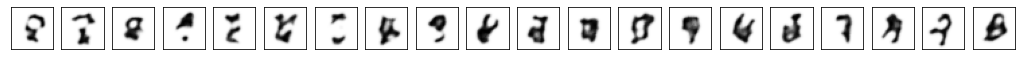

Unconditional samples with Temperature 1.0


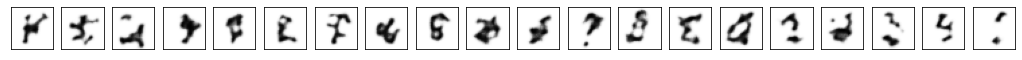

In [ ]:
from IPython import display

while(True):
    for batch_index, batch in enumerate(train_loader):

        # x : image (B, 1, 32, 32)
        x, t = batch
        x = x.cuda()

        # Backpropagation이 되도록 준비합니다.
        model.train()
        model.zero_grad()
        outputs = model(x)

        # Loss를 구하고 backpropagation을 통해 training을 진행합니다.
        loss = model.get_loss(x, outputs['x'], outputs['kl_divs'])
        loss['total_loss'].backward()
        optimizer.step()

        if step % 10 == 0:
            print('step :', step,
                  'recon_loss :', loss['recon_loss'].item(),
                  'kl_loss :', loss['kl_loss'].item())

        if step % 100 == 0:
            display.clear_output()

            _x = x.data.cpu().numpy()
            _y = np.clip(torch.sigmoid(outputs['x']).data.cpu().numpy(), 0, 1)
            plot(_x, 'Original')
            plot(_y, 'Reconstructed')
            
            model.eval()
            with torch.no_grad():
                samples00 = model.inference(batch=20, height=32, width=32, temperature=0.0)
                plot(samples00.data.cpu().numpy(), 'Unconditional samples with Temperature 0.0')
                samples03 = model.inference(batch=20, height=32, width=32, temperature=0.333)
                plot(samples03.data.cpu().numpy(), 'Unconditional samples with Temperature 0.333')
                samples06 = model.inference(batch=20, height=32, width=32, temperature=0.666)
                plot(samples06.data.cpu().numpy(), 'Unconditional samples with Temperature 0.666')
                samples10 = model.inference(batch=20, height=32, width=32, temperature=1.0)
                plot(samples10.data.cpu().numpy(), 'Unconditional samples with Temperature 1.0')
            
        step += 1
